In [2]:
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn import decomposition
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import csv
import time
import copy
import os
import tempfile

In [3]:
data = pd.read_csv('train_final.csv')
data.head()

,avg_travel_time,last_att,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,ls_0_in_out_diff,...,ls_5_117,ls_6_103,ls_6_118,ls_6_121,ls_8_101,ls_8_113,ls_7_106,ls_7_116,ls_7_122,ls_9_121
0,85.405,85.405,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
1,58.050,85.405,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
2,67.895,58.050,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
3,67.895,67.895,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
4,56.870,67.895,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0


In [15]:
train_data, val_data = train_test_split(data, test_size=0.20, shuffle=False)

train_target = np.array(train_data.pop('avg_travel_time'))
val_target = np.array(val_data.pop('avg_travel_time'))

In [16]:
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / y_true), axis=-1)

def build_model(dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=dim,
                     kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(16, activation='relu',
                    kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(8, activation='relu',
                    kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(1,activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=[mape])
    
    return model

class PrintProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('.', end='')
        if (epoch+1) % 10 == 0: 
            print(' ')
            logs_new = copy.deepcopy(logs)
            print(logs_new)


In [22]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min', verbose=1)            
            
EPOCHS = 50

model = build_model(train_data.shape[1])

history = model.fit(
    train_data, train_target,
    shuffle=False,
    epochs=EPOCHS, verbose=0, validation_data=(val_data, val_target), batch_size=100,
    callbacks=[PrintProgress()])

.......... 
{'loss': 22.55453294131186, 'mape': 0.20252743, 'val_loss': 29.709262221012974, 'val_mape': 0.15250923}
.......... 
{'loss': 22.085831394178573, 'mape': 0.19804865, 'val_loss': 33.210125036440985, 'val_mape': 0.16589889}
.......... 
{'loss': 21.8127229518524, 'mape': 0.1959526, 'val_loss': 35.32123427778005, 'val_mape': 0.17453443}
.......... 
{'loss': 21.56500878520267, 'mape': 0.19416174, 'val_loss': 37.11759506415787, 'val_mape': 0.18303011}
.......... 
{'loss': 21.38785775158791, 'mape': 0.19255526, 'val_loss': 38.90373212901183, 'val_mape': 0.19063875}


In [18]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
    plt.legend()
    
    plt.show()

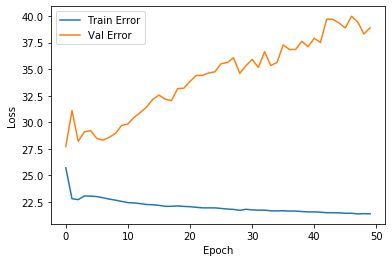

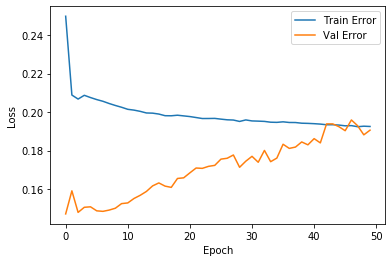

In [24]:
plot_history(history)

In [25]:
model.save('feedforward_neural_network')

INFO:tensorflow:Assets written to: feedforward_neural_network/assets


In [10]:
test_data = pd.read_csv('test_final.csv')
test_data.head()

,avg_travel_time,last_att,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,ls_0_in_out_diff,...,ls_5_117,ls_6_103,ls_6_118,ls_6_121,ls_8_101,ls_8_113,ls_7_106,ls_7_116,ls_7_122,ls_9_121
0,41.097143,41.097143,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
1,43.681667,41.097143,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
2,68.024286,43.681667,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
3,52.608333,68.024286,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
4,56.165556,52.608333,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0


In [11]:
test_label = test_data.pop('avg_travel_time')

In [23]:
result = model.predict(np.array(test_data))
mape_score = np.mean(np.abs((test_label - [r[0] for r in result]) / test_label))
mape_score

0.20653585575755673

# missing data was not added

In [26]:
data_m = pd.read_csv('train_final_no_missing.csv')
data_m.head()

,avg_travel_time,last_att,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,ls_0_in_out_diff,...,ls_5_117,ls_6_103,ls_6_118,ls_6_121,ls_8_101,ls_8_113,ls_7_106,ls_7_116,ls_7_122,ls_9_121
0,58.05,58.05,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
1,56.87,58.05,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
2,77.74,56.87,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
3,42.64,77.74,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
4,40.17,42.64,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0


In [27]:
train_data_m, val_data_m = train_test_split(data_m, test_size=0.20, shuffle=False)

train_target_m = np.array(train_data_m.pop('avg_travel_time'))
val_target_m = np.array(val_data_m.pop('avg_travel_time'))

In [28]:
EPOCHS = 50

model_m = build_model(train_data_m.shape[1])

history = model_m.fit(
    train_data_m, train_target_m,
    shuffle=False,
    epochs=EPOCHS, verbose=0, validation_data=(val_data_m, val_target_m), batch_size=100,
    callbacks=[PrintProgress()])

.......... 
{'loss': 24.44271936968965, 'mape': 0.23443809, 'val_loss': 53.75465910390633, 'val_mape': 0.2556132}
.......... 
{'loss': 24.301979002358753, 'mape': 0.23322757, 'val_loss': 56.64532170852294, 'val_mape': 0.2688575}
.......... 
{'loss': 24.13727013163385, 'mape': 0.23238447, 'val_loss': 57.38911121146156, 'val_mape': 0.27295017}
.......... 
{'loss': 23.97774223139889, 'mape': 0.23142096, 'val_loss': 57.260768449669165, 'val_mape': 0.27206025}
.......... 
{'loss': 23.92958382519507, 'mape': 0.23104233, 'val_loss': 55.768484897275975, 'val_mape': 0.26474106}


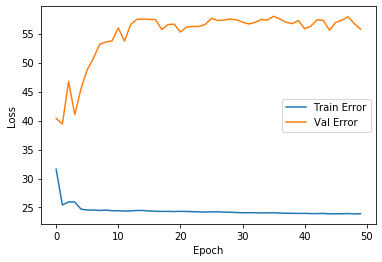

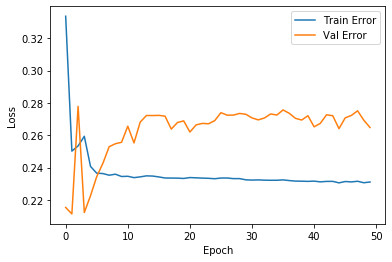

In [29]:
plot_history(history)

In [30]:
result_m = model_m.predict(np.array(test_data))
mape_score_m = np.mean(np.abs((test_label - [r[0] for r in result_m]) / test_label))
mape_score_m

0.23857377072742952